Jose Miguel Bautista

Updated: Sep 6, 2024

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# If you want to use the ellipse plotter function at the end
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

# If you want to practice on a few of the sklearn stuff
from scipy.spatial.distance import euclidean
from sklearn.datasets import fetch_20newsgroups, fetch_openml, load_wine
from sklearn.preprocessing import StandardScaler

In [2]:
np.set_printoptions(suppress=True,precision=6)

# Context: Multi-dimensional Data

It is often the case that you will be working with data in multiple dimensions.

For example, if you have the historical price data of 100 stocks, each tick of time would give you a 100-dimensional data point. 

Very generally - many dimensions are inconvenient to work with. Not only do they slow down all of your computations, they tend to obfuscate the important relationships in the data.

Thus, it is a good idea to try and reduce the number of dimensions under consideration by focusing on the most important ones.

Principal component analysis (PCA) is one such way to quantitatively find the most important relationships between the data.

### A Simplified Example: 2-D Gaussian

Consider a set of 10000 data points in 2-dimensions. 

If you like, you can imagine each point is tick data, and the dimensions are price changes of 2 possible stocks (say, Apple and Microsoft) at that instant.

Each stock is distributed according to its own Gaussian distribution, centered at 0, and they are **completely independent** for now.

We can generate this with numpy's `multivariate_normal` command with vanishing covariance (off-diagonal) terms. 

WLOG, I am also taking one of the variances to be $10\times$ the other. 

Then observe the resulting distributions.

In [3]:
N = 10000
mean = np.array([0, 0])
cov = np.array([[20, 0], 
                [0, 2]])

pts = np.random.multivariate_normal(mean, cov, size=N)

# guidelines for later
axs_x = np.array([[0, 3*cov[0, 0]**0.5], [0, 0]])
axs_y = np.array([[0, 0], [0, 3*cov[1, 1]**0.5]])

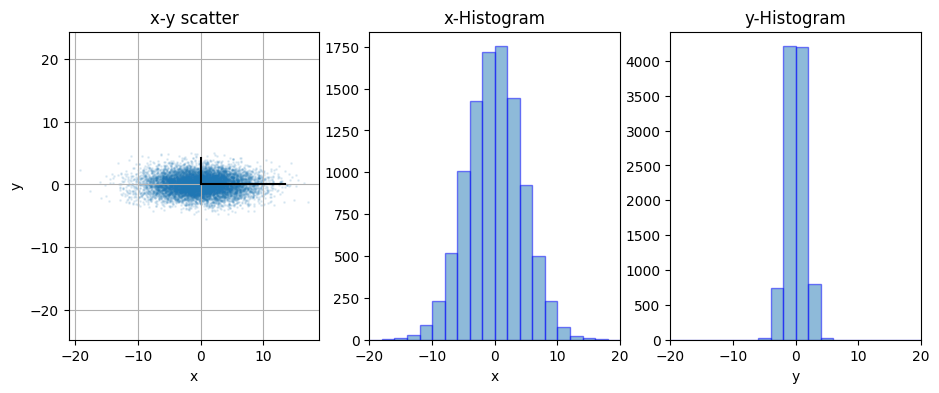

In [4]:
nbins = np.linspace(-200, 200, 200+1) # for histograms

fig, axs = plt.subplots(1, 3, figsize=(11, 4))

axs[0].scatter(pts[:, 0], pts[:, 1], s=1, alpha = 0.1)
axs[0].plot(axs_x[0], axs_x[1], color = 'k')
axs[0].plot(axs_y[0], axs_y[1], color = 'k')
#confidence_ellipse(pts[:, 0], pts[:, 1], axs, edgecolor='red')

axs[1].hist(pts[:, 0], bins = nbins, alpha = 0.5, edgecolor = 'b')
axs[1].set_xlim(-np.max(cov), np.max(cov))
axs[2].hist(pts[:, 1], bins = nbins, alpha = 0.5, edgecolor = 'b')
axs[2].set_xlim(-np.max(cov), np.max(cov))

axs[0].axis('equal')
axs[0].grid()
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title('x-y scatter')
axs[1].set_xlabel('x')
axs[1].set_title('x-Histogram')
axs[2].set_xlabel('y')
axs[2].set_title('y-Histogram')
plt.show()

Above I plotted the 2-D scatter plot of the data, as well as the 1-D histograms along each axis.

For the scatter, I have also plotted guide lines equal to $3\times$ the standard deviation from my covariance matrix.

Perhaps unsurprisingly, the scatter plot looks like an ellipse where the axes are aligned with the x- and y-axes. 

The histograms have different heights and widths, because I set the variances at 20 and 2 for x- and y- respectively. One can imagine the histograms are projections, "shadows" if you will, of the full 2-D ellipse.

If you wanted to check the empirical covariance recovers the simulation parameters, use the code below.

In [5]:
np.cov(pts, rowvar=False, bias=True)

array([[19.796817, -0.007642],
       [-0.007642,  1.995461]])

### Correlated Data 1

In reality, many variables we measure are actually related. 

I am going to first *simulate* this by rotating my dataset $45^o$ counter-clockwise and plot for visualization purposes.

Even though this is not a particularly realistic thing to do, there is a mathematical reason for this, so bear with me.

To handle the rotation we can use a standard [rotation matrix](https://en.wikipedia.org/wiki/Rotation_matrix). 

In [6]:
theta = np.pi/4
rot = np.array([[np.cos(theta), -np.sin(theta)], 
                [np.sin(theta), np.cos(theta)]])

pts_rot = (rot@pts.T).T

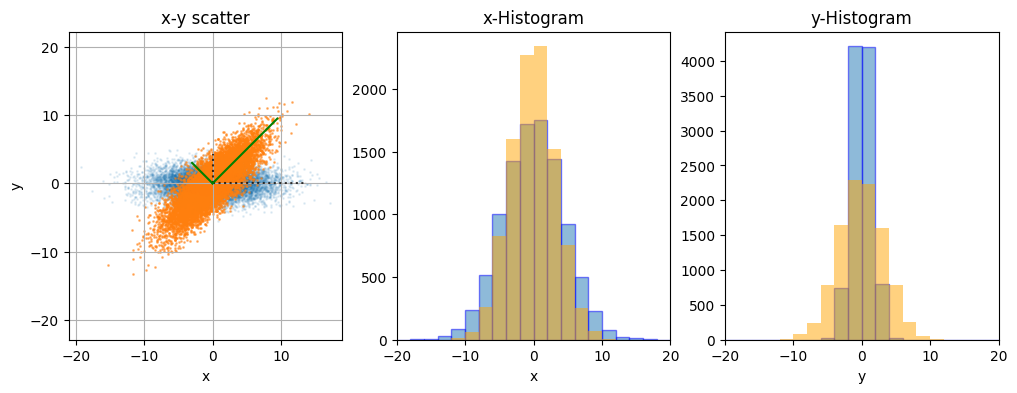

In [7]:
axs_rot_x = rot@axs_x
axs_rot_y = rot@axs_y

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].scatter(pts[:, 0], pts[:, 1], s=1, alpha = 0.1)
axs[0].plot(axs_x[0], axs_x[1], color = 'k', linestyle = ':', alpha = 0.75)
axs[0].plot(axs_y[0], axs_y[1], color = 'k', linestyle = ':', alpha = 0.75)

axs[0].scatter(pts_rot[:, 0], pts_rot[:, 1], s=1, alpha = 0.5)
axs[0].plot(axs_rot_x[0], axs_rot_x[1], color = 'g')
axs[0].plot(axs_rot_y[0], axs_rot_y[1], color = 'g')
#confidence_ellipse(pts_rot[:, 0], pts_rot[:, 1], axs, edgecolor='red')

axs[1].hist(pts[:, 0], bins = nbins, alpha = 0.5, edgecolor = 'b')
axs[1].hist(pts_rot[:, 0], bins = nbins, alpha = 0.5, facecolor = 'orange')
axs[1].set_xlim(-np.max(cov), np.max(cov))
axs[2].hist(pts[:, 1], bins = nbins, alpha = 0.5, edgecolor = 'b')
axs[2].hist(pts_rot[:, 1], bins = nbins, alpha = 0.5, facecolor = 'orange')
axs[2].set_xlim(-np.max(cov), np.max(cov))

axs[0].axis('equal')
axs[0].grid()
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title('x-y scatter')
axs[1].set_xlabel('x')
axs[1].set_title('x-Histogram')
axs[2].set_xlabel('y')
axs[2].set_title('y-Histogram')
plt.show()

As one might expect, the lengths of the ellipse axes (black lines) don't actually change with the rotation, while their direction does.

The widths of the x/y- histograms also change because the ellipse now projects onto smaller/larger areas respectively. 

In this case, the x- and y- histograms should be approximately the same shape.

If you check the covariance matrix now, we have in-fact introduced covariance (off-diagonal terms) at the expense of the individual variances (diagonal terms).

In [8]:
np.cov(pts_rot, rowvar=False, bias=True)

array([[10.903781,  8.900678],
       [ 8.900678, 10.888497]])

### Correlated Data 2

Now I want to actually generate correlated data; I could use the one I got above (numerically) to simulate it.

But it turns out I can use the same rotation matrix to *directly rotate the covariance matrix* and it will generate the same distribution. 

To rotate a matrix, you need to multiply the rotation to the left and inverse inverse/transpose to the right. 

**Sidenote**: If you're wondering why the rotation of a matrix looks like that, it can be understood as rotating both rows and columns (typical answer).
But I prefer to think of it in terms of coordinate systems between the vector and matrix.

Consider multiplying a vector to the right of the rotated matrix.
1. The right-most rotation matrix de-rotates it into the coordinate system of the matrix (the one which made the blue scatter).
2. The original matrix then acts to transform the vector.
3. To end, you have to re-rotate the transformed vector back into its own original coordinate system with the left-most rotation matrix.

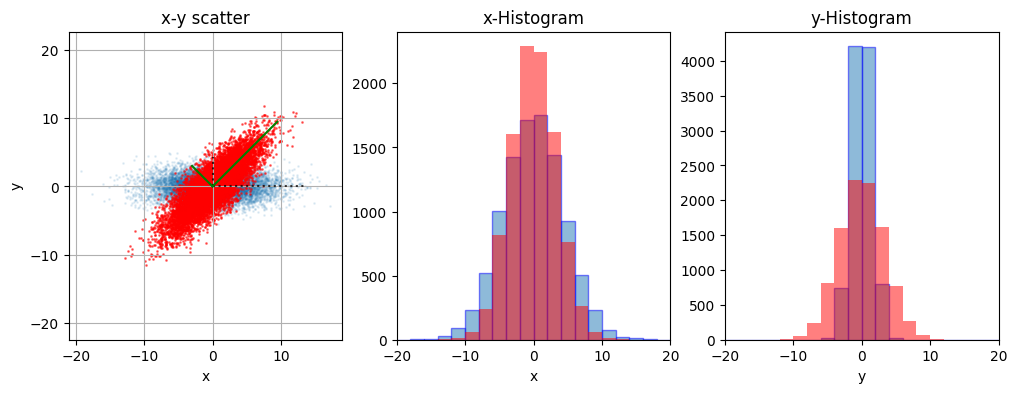

In [9]:
cov_rot = rot@cov@rot.T

pts_rot2 = np.random.multivariate_normal(mean, cov_rot, size=N)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].scatter(pts[:, 0], pts[:, 1], s=1, alpha = 0.1)
axs[0].plot(axs_x[0], axs_x[1], color = 'k', linestyle = ':', alpha = 0.75)
axs[0].plot(axs_y[0], axs_y[1], color = 'k', linestyle = ':', alpha = 0.75)

axs[0].plot(axs_rot_x[0], axs_rot_x[1], color = 'g')
axs[0].plot(axs_rot_y[0], axs_rot_y[1], color = 'g')

axs[0].scatter(pts_rot2[:, 0], pts_rot2[:, 1], color='r', s=1, alpha = 0.5)

#confidence_ellipse(pts_rot[:, 0], pts_rot[:, 1], axs[0], edgecolor='red')

axs[1].hist(pts[:, 0], bins = nbins, alpha = 0.5, edgecolor = 'b')
axs[1].hist(pts_rot2[:, 0], bins = nbins, alpha = 0.5, facecolor = 'red')
axs[1].set_xlim(-np.max(cov), np.max(cov))
axs[2].hist(pts[:, 1], bins = nbins, alpha = 0.5, edgecolor = 'b')
axs[2].hist(pts_rot2[:, 0], bins = nbins, alpha = 0.5, facecolor = 'red')
axs[2].set_xlim(-np.max(cov), np.max(cov))

axs[0].axis('equal')
axs[0].grid()
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title('x-y scatter')
axs[1].set_xlabel('x')
axs[1].set_title('x-Histogram')
axs[2].set_xlabel('y')
axs[2].set_title('y-Histogram')
plt.show()

In [10]:
cov_rot #just to show it gives approximately the same result as the data rotation 

array([[11.,  9.],
       [ 9., 11.]])

**My main point:** the (arguably unnatural) rotation of *uncorrelated* data is mathematically equivalent to the generation of intrisically *correlated* data through the rotation matrix for Gaussian-distributed data. 

So the idea behind PCA is that if your data is blobby/ellipse shaped (like the red-scatter), you want to find the axes of the best-fitting ellipse in order to capture the most important variables, or linear combinations thereof.

Your empirical covariance matrix will likely have both diagonal and off-diagonal terms, so to read off the axes lengths and orientations, you need to bring it back to diagonal form (read: [diagonalization](https://en.wikipedia.org/wiki/Diagonalizable_matrix#Diagonalization)).

To reiterate: given some correlated variables (the red scatter), the data is fit by some ellipse whose axes (green) are totally uncorrelated linear combinations of the variables.

In order to find the lengths/orientations axes of the best-fit ellipse, you need to find the underlying diagonal matrix (the one that made the blue scatter).

The axes lengths are the eigenvalues (entries of the diagonalized matrix), while the orientations are given by the corresponding eigenvectors.

The eigenvectors are the "principal components" or "PC" in the name PCA.

# Higher Dimensions

In higher dimensions, this picture still works (fitting an n-dimensional ellipse to your n-dimensional dataset and finding the axes), but it's far harder to visualize because you'd have to do the rotations along multiple axes and projections.

So to generalize, here is the algorithm:

1. Mean-centering: subtract the average value from each dimension (you need to do this to ensure the rotation works).
2. Empirical Covariance: get the entries of the covariance matrix for your mean-centered data with something like `np.cov`
3. Diagonalization: bring the empirical covariance matrix into diagonal form and get the eigenvectors/eigenvalues. I'd pick something easy like `np.linalg.eig`.

Then you're pretty much done - the axis lengths are the eigenvalues, while the axis directions are the eigenvectors. 

Alternatively, you could use the `PCA` command in [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

# Dimension Reduction

What happens if one of the diagonal terms in the original covariance matrix is extremely small, nearly vanishing?

Check for the 2-D case.

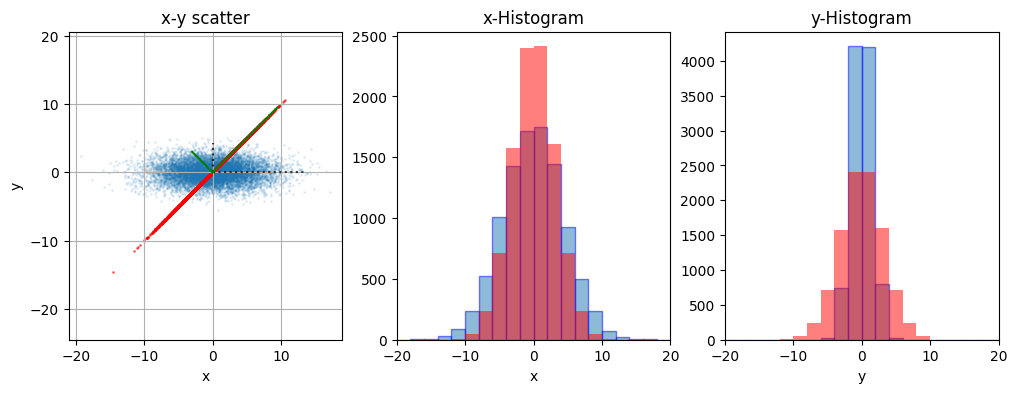

In [11]:
cov2 = np.array([[20, 0], 
                [0, 0.000002]])

cov2_rot = rot@cov2@rot.T

pts2_rot2 = np.random.multivariate_normal(mean, cov2_rot, size=N)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].scatter(pts[:, 0], pts[:, 1], s=1, alpha = 0.1)
axs[0].plot(axs_x[0], axs_x[1], color = 'k', linestyle = ':', alpha = 0.75)
axs[0].plot(axs_y[0], axs_y[1], color = 'k', linestyle = ':', alpha = 0.75)

axs[0].plot(axs_rot_x[0], axs_rot_x[1], color = 'g')
axs[0].plot(axs_rot_y[0], axs_rot_y[1], color = 'g')

axs[0].scatter(pts2_rot2[:, 0], pts2_rot2[:, 1], color='r', s=1, alpha = 0.5)

#confidence_ellipse(pts_rot[:, 0], pts_rot[:, 1], axs[0], edgecolor='red')

axs[1].hist(pts[:, 0], bins = nbins, alpha = 0.5, edgecolor = 'b')
axs[1].hist(pts2_rot2[:, 0], bins = nbins, alpha = 0.5, facecolor = 'red')
axs[1].set_xlim(-np.max(cov), np.max(cov))
axs[2].hist(pts[:, 1], bins = nbins, alpha = 0.5, edgecolor = 'b')
axs[2].hist(pts2_rot2[:, 0], bins = nbins, alpha = 0.5, facecolor = 'red')
axs[2].set_xlim(-np.max(cov), np.max(cov))

axs[0].axis('equal')
axs[0].grid()
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_title('x-y scatter')
axs[1].set_xlabel('x')
axs[1].set_title('x-Histogram')
axs[2].set_xlabel('y')
axs[2].set_title('y-Histogram')
plt.show()

As you can guess and see, the minor axis of the ellipse vanishes, and the 2-D scatter collapses to a line.

    n.b. You would not be able to see this looking at only the histograms of x- and y-.

So in practice, this is not really a 2-D problem. We just measured it in 2-D because it was the most convenient option to do so.

PCA reveals to us that it is effectively a 1-D problem - data is almost entirely described by its position along one of the axes (PCs).

For higher dimensions, we would apply the same idea: whenever the axis length (read:eigenvalue) is below a certain threshold, the associated PC can be removed from further analysis because the data does not vary much along that axis. 

This is the basis of [scree plots](https://en.wikipedia.org/wiki/Scree_plot).

### Note on dimension reduction

Scree plots are great and all, but it is often not the case that many of your eigenvalues will have a clear/meaningful break point (unless you had domain knowledge of your problem).

So what people usually do is to convert the scree plot to cumulative variance plots (by taking the cumuluative sum) and setting a threshold on that instead. 

[Here](https://statisticallyrelevant.com/principal-component-analysis-in-python/) is a page that does both, and illustrates the difference.

In [12]:
# Taken straight from the documentation
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The Axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)